In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import joblib

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("./data/spam.csv", encoding = "latin1")

In [4]:
df = df[["v2", "v1"]]

In [5]:
df.rename(columns = {"v2": "message", "v1": "label"}, inplace = True)

In [6]:
df["label"] = df["label"].replace({"ham": 0, "spam": 1})

In [7]:
df

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


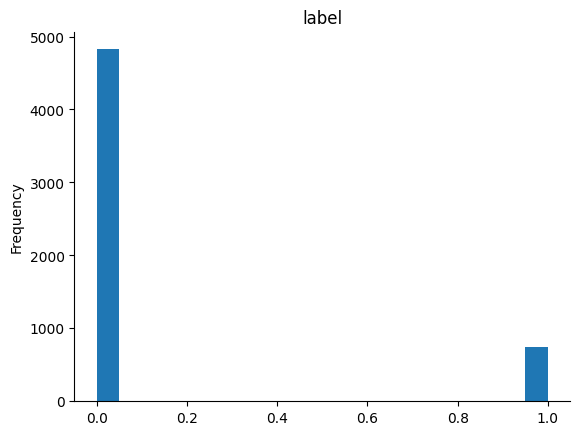

In [8]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
def clean_text(text):
    text = re.sub(r"(?<=\d)\.(?=\d)", "", text)
    text = re.sub(r"(?<=\w)\\'(?=\w)", "", text)
    text = re.sub(r"(?<=\w)\'(?=\w)", "", text)
    text = re.sub(r"&lt;#&gt;", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text.strip()

In [10]:
df["cleaned_message"] = df["message"].apply(clean_text)

In [11]:
def preprocess_text(text):
    text = " ".join([WordNetLemmatizer().lemmatize(token) for token in word_tokenize(text) if token not in set(stopwords.words("english"))])
    return text.strip()

In [12]:
df["preprocessed_message"] = df["cleaned_message"].apply(preprocess_text)

In [13]:
df = df.drop_duplicates()

In [14]:
df = df[~(df["preprocessed_message"].str.len() == 0)]

In [15]:
df = df[~(df["preprocessed_message"].str.split().apply(len) <= 1)]

In [16]:
df

,message,label,cleaned_message,preprocessed_message
0,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...,nah dont think go usf life around though
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u 750 pound prize 2...
5568,Will Ì_ b going to esplanade fr home?,0,will b going to esplanade fr home,b going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",0,pity was in mood for that so any other suggest...,pity mood suggestion
5570,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...


In [17]:
for i in range(1490, 1501):
    print(df.iloc[i]["message"])
    print(df.iloc[i]["cleaned_message"])
    print(df.iloc[i]["preprocessed_message"])
    print()

Dude just saw a parked car with its sunroof popped up. Sux
dude just saw a parked car with its sunroof popped up sux
dude saw parked car sunroof popped sux

Get ready to put on your excellent sub face :)
get ready to put on your excellent sub face
get ready put excellent sub face

Tmrw. Im finishing 9 doors
tmrw im finishing 9 doors
tmrw im finishing 9 door

The  &lt;#&gt; g that i saw a few days ago, the guy wants sell wifi only for  &lt;#&gt;  and with 3g for  &lt;#&gt; . That's why i blanked him.
the g that i saw a few days ago the guy wants sell wifi only for and with 3g for thats why i blanked him
g saw day ago guy want sell wifi 3g thats blanked

whatever, im pretty pissed off.
whatever im pretty pissed off
whatever im pretty pissed

I dont have that much image in class.
i dont have that much image in class
dont much image class

No:-)i got rumour that you going to buy apartment in chennai:-)
no i got rumour that you going to buy apartment in chennai
got rumour going buy apartmen

# Count Vectorizer

In [18]:
count_vectorizer = CountVectorizer(max_features = 5000, binary = True, ngram_range = (1, 3))

X = count_vectorizer.fit_transform(list(df["preprocessed_message"])).toarray()

y = df["label"].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       885
           1       0.96      0.93      0.95       133

    accuracy                           0.99      1018
   macro avg       0.98      0.96      0.97      1018
weighted avg       0.99      0.99      0.99      1018



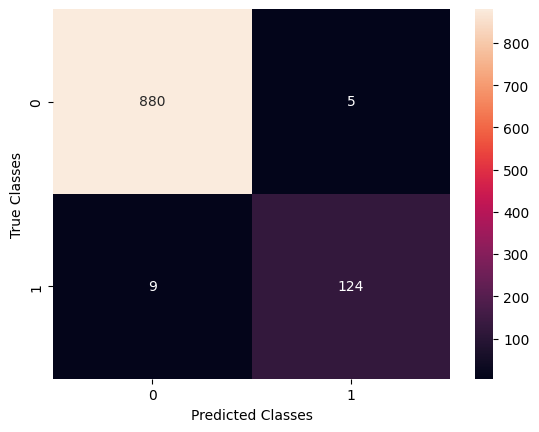

In [21]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()

naive_bayes_classifier.fit(X_train, y_train)

predictions = naive_bayes_classifier.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# TF-IDF

In [22]:
tf_idf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1, 3))

X = tf_idf_vectorizer.fit_transform(list(df["preprocessed_message"])).toarray()

y = df["label"].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       885
           1       1.00      0.83      0.91       133

    accuracy                           0.98      1018
   macro avg       0.99      0.91      0.95      1018
weighted avg       0.98      0.98      0.98      1018



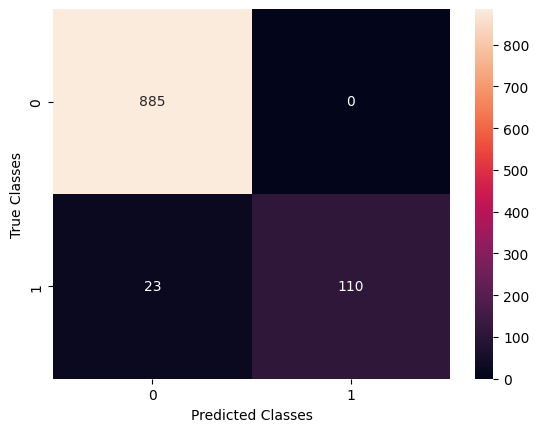

In [24]:
naive_bayes_classifier = MultinomialNB()

naive_bayes_classifier.fit(X_train, y_train)

predictions = naive_bayes_classifier.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# Word2Vec


In [25]:
tokenized_sentences = [word_tokenize(sentence) for sentence in list(df["preprocessed_message"])]

In [26]:
tokenized_sentences[1]

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

In [27]:
model = Word2Vec(sentences = tokenized_sentences, window = 5, min_count = 1)

In [28]:
model.build_vocab(tokenized_sentences)

In [29]:
model.train(tokenized_sentences, total_examples = model.corpus_count, epochs = model.epochs)

(225012, 243350)

In [30]:
f"Our vocabulary has {len(model.wv.index_to_key)} unique elements"

'Our vocabulary has 8038 unique elements'

In [31]:
model.wv.most_similar("free")

[('nokia', 0.9997187852859497),
 ('mobile', 0.9996893405914307),
 ('reply', 0.9996739029884338),
 ('claim', 0.9996697902679443),
 ('tone', 0.9996664524078369),
 ('call', 0.9996405243873596),
 ('txt', 0.9996286630630493),
 ('100', 0.9996150135993958),
 ('stop', 0.9995975494384766),
 ('text', 0.9995918273925781)]

In [32]:
model.wv["prize"]

array([-0.20828244,  0.5843841 ,  0.00222615, -0.17631002,  0.2427742 ,
       -1.0772492 ,  0.1912661 ,  1.26013   , -0.37017372, -0.28445336,
       -0.23822144, -1.0415628 , -0.3104925 ,  0.27819076,  0.05396155,
       -0.6259165 ,  0.18422948, -0.5674394 ,  0.10160602, -1.0457132 ,
        0.4314292 ,  0.28308716,  0.42200992, -0.31398782,  0.04667876,
       -0.1117588 , -0.30525008, -0.39080715, -0.63189065,  0.07308821,
        0.69247264,  0.11126911,  0.16886815, -0.5386522 , -0.29720503,
        0.8064579 ,  0.00184217, -0.42291975, -0.21230808, -1.1434345 ,
        0.13656756, -0.58194983, -0.3682263 , -0.07694525,  0.6453607 ,
       -0.2817318 , -0.56149983, -0.14172697,  0.2544301 ,  0.39670882,
        0.2620549 , -0.5393322 , -0.1486125 , -0.16608411, -0.4399216 ,
        0.46635428,  0.48067424, -0.03348114, -0.58610314,  0.18594785,
        0.18373089,  0.1182519 , -0.3024748 , -0.18972628, -0.6932501 ,
        0.41371334,  0.3057121 ,  0.46205896, -0.81582457,  0.89

In [33]:
def average_word2vec(doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key], axis = 0)

In [34]:
X = []

for sentence in tokenized_sentences:
    X.append(average_word2vec(sentence))

In [35]:
for array in X:
    if len(array.shape) == 0:
        print(array.shape)

In [36]:
X = np.array(X)

In [37]:
y = df["label"].values

In [38]:
X.shape, y.shape

((5087, 100), (5087,))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [40]:
pd.Series(y_train).value_counts()

0    3549
1     520
Name: count, dtype: int64

In [41]:
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

In [42]:
pd.Series(y_train).value_counts()

0    3549
1    3549
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       0.93      0.64      0.76       885
           1       0.22      0.70      0.34       133

    accuracy                           0.64      1018
   macro avg       0.58      0.67      0.55      1018
weighted avg       0.84      0.64      0.70      1018



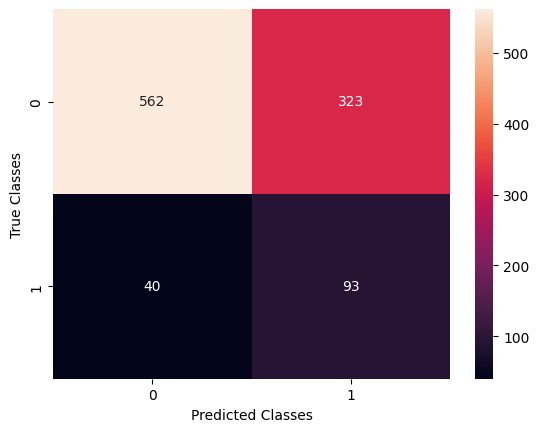

In [43]:
from sklearn.naive_bayes import MultinomialNB

ham_vs_spam_classifier = Pipeline([("scaler", MinMaxScaler()), ("classifier", MultinomialNB())])

ham_vs_spam_classifier.fit(X_train, y_train)

predictions = ham_vs_spam_classifier.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.98      0.90      0.94       885
           1       0.56      0.87      0.68       133

    accuracy                           0.89      1018
   macro avg       0.77      0.89      0.81      1018
weighted avg       0.92      0.89      0.90      1018



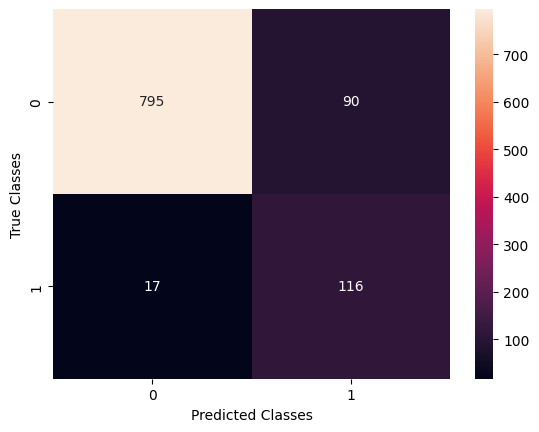

In [44]:
from sklearn.linear_model import LogisticRegression

ham_vs_spam_classifier1 = Pipeline([("scaler", MinMaxScaler()), ("classifier", LogisticRegression())])

ham_vs_spam_classifier1.fit(X_train, y_train)

predictions = ham_vs_spam_classifier1.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       885
           1       0.69      0.74      0.72       133

    accuracy                           0.92      1018
   macro avg       0.83      0.85      0.84      1018
weighted avg       0.93      0.92      0.92      1018



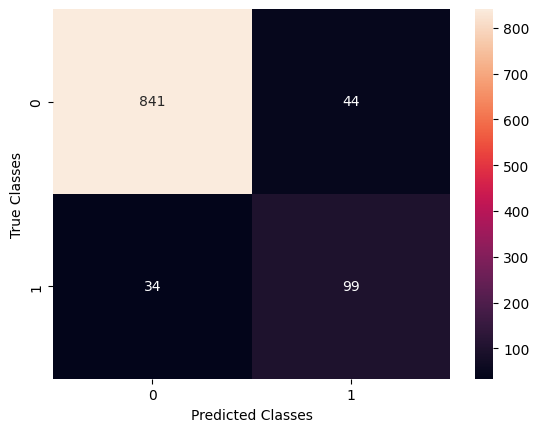

In [45]:
from sklearn.tree import DecisionTreeClassifier

ham_vs_spam_classifier2 = Pipeline([("scaler", MinMaxScaler()), ("classifier", DecisionTreeClassifier())])

ham_vs_spam_classifier2.fit(X_train, y_train)

predictions = ham_vs_spam_classifier2.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       885
           1       0.88      0.80      0.84       133

    accuracy                           0.96      1018
   macro avg       0.92      0.89      0.91      1018
weighted avg       0.96      0.96      0.96      1018



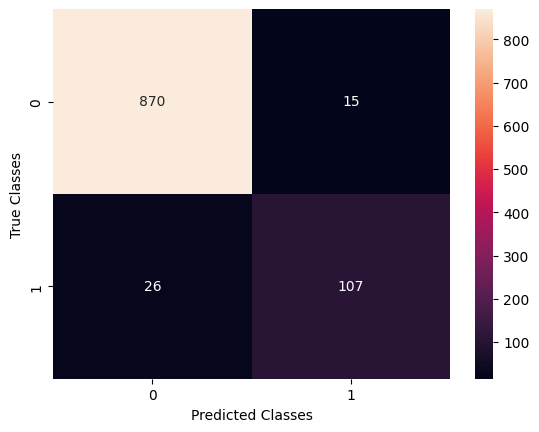

In [46]:
from sklearn.ensemble import RandomForestClassifier

ham_vs_spam_classifier3 = Pipeline([("scaler", MinMaxScaler()), ("classifier", RandomForestClassifier())])

ham_vs_spam_classifier3.fit(X_train, y_train)

predictions = ham_vs_spam_classifier3.predict(X_test)

print(classification_report(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

In [47]:
def predict(text):
    cleaned_text = clean_text(text)
    preprocessed_text = preprocess_text(cleaned_text)
    tokenized_text = word_tokenize(preprocessed_text)
    mean_vector = average_word2vec(tokenized_text)
    prediction = ham_vs_spam_classifier.predict([mean_vector])
    if prediction == 0:
        return "The message is ham"
    else:
        return "The message is spam"

In [50]:
predict("my name is nexus")

'The message is ham'

In [51]:
model.save("hamvsspamword2vec.model")

In [52]:
joblib.dump(ham_vs_spam_classifier3, "hamvsspamclassifier.pkl")

['hamvsspamclassifier.pkl']